In [1]:
# Imports
import io
import platform
from PIL import Image
from urllib.request import urlopen

import flasgger
from flask_restful import Api
from flask_restful import Resource, fields, marshal
from flask import Flask, render_template_string, request, redirect
from flask_ngrok import run_with_ngrok


import torch
from torchvision import models
import torchvision.transforms as transforms


In [2]:
# Paste your ngrok authtoken below and run the cell

## Uncomment the line below
!ngrok authtoken 2b5qadLVnc37ityi7SdRzvgHMwV_6xMPe2RgT4fZwy7RwTDm3

Authtoken saved to configuration file: /Users/rodrigo/Library/Application Support/ngrok/ngrok.yml


In [12]:
# Load a pre-trainied DenseNet model from torchvision.models
model = models.densenet121(pretrained=True)

# Switch the model to evaluation mode
model.eval()

# Load the class labels from a file
class_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_labels = urlopen(class_labels_url).read().decode("utf-8").split("\n")

# Define the transformation of the input image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/opt/homebrew/Caskroom/miniforge/base/envs/Ising_Deployment/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Ising_Deployment/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
def predict(model, transform, image, class_labels):
  # Transform the image and convert it to a tensor
  image_tensor = transform(image).unsqueeze(0)

  # Pass the image through the model
  with torch.no_grad():
    output = model(image_tensor)


  # Select the class with the higherst probability and look up the name
  m = torch.nn.Softmax(dim=1)
  class_prob = round(float(m(output).max()),3)*100
  class_id = torch.argmax(output).item()
  class_name = class_labels[class_id]

  # Return the class name
  return str(class_name) + " - Confidence: " + str(class_prob) +  '%'

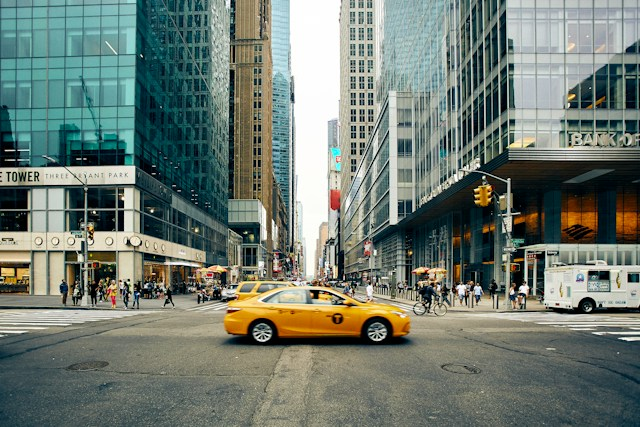

'cab - Confidence: 99.8%'

In [26]:
# Load and display the image
dog_image = Image.open(io.BytesIO(urlopen("https://unsplash.com/photos/I5yMF33r3s8/download?force=true&w=640").read()))
display(dog_image)

# Classify the image
display(predict(model, transform, dog_image, class_labels))

In [15]:
index_template = """
<html>
    <head>
        <!-- Load vue.js and axois.js -->
        <script src="https://cdn.jsdelivr.net/npm/vue/dist/vue.js"></script>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/axios/0.21.1/axios.min.js"></script>
    </head>
    <body>
        <!-- The APP UI -->
        <div id="app" style="width: 50%; margin: 200px auto">
            <form id="imageForm" enctype="multipart/form-data" method="POST" style="text-align: center; display: block">
                <label for="imageFile">Select image to classify:</label
                ><input id="imageFile" name="file" type="file" style="margin-left: 10px" />

                <img v-if="image" :src="image" style="width: 250px; display: block; margin: 50px auto 10px" />
                <div v-if="prediction" style="font-size: 32px; font-weight: bold; text-align: center">
                    {{ prediction }}
                </div>
                <input v-if="image" type="submit" value="Classify Image" style="margin: 20px 20px" />
            </form>
        </div>

        <script>
            <!-- The Vue application -->
            var app = new Vue({
                el: "#app",
                data() {
                    return {
                        image: null,
                        prediction: null,
                    };
                },
            });

            <!-- Calling the predict API when the form is submitted -->
            document.getElementById("imageForm").addEventListener("submit", (e) => {
                axios
                    .post("/predict", new FormData(document.getElementById("imageForm")), {
                        headers: {
                            "Content-Type": "multipart/form-data",
                        },
                    })
                    .then((response) => (app.prediction = response.data));

                e.preventDefault();
            });

            <!-- Display the selected image -->
            document.getElementById("imageFile").addEventListener("change", (e) => {
                const [file] = document.getElementById("imageFile").files;
                if (file) {
                    app.image = URL.createObjectURL(file);
                }
            });
        </script>
    </body>
</html>
"""

In [ ]:
app = Flask(__name__)

# Serve the template with the interactive UI
@app.route("/")
def home():
  return index_template


# Classification API
@app.route("/predict", methods=['POST'])
def predict_api():
  # Fetch the image from the request and convert it to a Pillow image
  image_file = request.files['file']
  image_bytes = image_file.read()
  image = Image.open(io.BytesIO(image_bytes))

  # Predict the class from the image
  class_name = predict(model, transform, image, class_labels)

  # Return the result
  return class_name

# Run the app
run_with_ngrok(app)

## Uncomment below to run the app
app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/Ising_Deployment/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/Ising_Deployment/lib/python3.10/threading.py", line 1378, in run
    self.function(*self.args, **self.kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/Ising_Deployment/lib/python3.10/site-packages/flask_ngrok.py", line 70, in start_ngrok
    ngrok_address = _run_ngrok()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/Ising_Deployment/lib/python3.10/site-packages/flask_ngrok.py", line 29, in _run_ngrok
    os.chmod(executable, 777)
FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/24/hz8c6rbx3r32smymhrvkwbmc0000gn/T/ngrok/ngrok'
127.0.0.1 - - [02/Feb/2024 12:49:27] "GET / HTTP/1.1" 200 -
[2024-02-02 12:49:31,754] ERROR in app: Exception on /pr